In [1]:
import numpy as np
import xarray
import os
from matplotlib import pyplot as plt
import scipy.signal as scipy_signal
import scipy.stats as scipy_stats
from geopy import distance as geo_dist
import cmocean
import pandas
import gsw as TEOS_10
import os
import proplot
import cartopy.feature as cfeature


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]


In [2]:
def align_lon(ds,lon_name_list):
    """
    align_lon
    Returns: ds
    Defaults:
    Author: Thomas Moore (based on Dougie Squire code)
    Date created: 28/01/2020

    Assumptions:
    Dataset = ds
    Use: ds_aligned = align_lon(ds,lon_name_list)
    """
    for lon_name in lon_name_list:
        ds_attrs = ds[lon_name].attrs
        ds = ds.assign_coords({lon_name: (ds[lon_name] + 360)  % 360}).sortby(lon_name)
        ds[lon_name].attrs = ds_attrs
    return ds

In [22]:
from shapely.geometry import Point, Polygon
from shapely.geometry import Polygon, mapping
import matplotlib.path as matplotlib_path


def mask_inside_boundaries(ds,shapereader_boundary_object,
                           eco_code_bdy_object_key,
                           eco_codes_to_get,
                           eco_region_key = 'ECOREGION',
                           sensor_dims=['lat','lon'],shift_lons_to_n180_p180=True):
    #lat_region = chla_dataset_year_avg['lat'].sel(lat=slice(current_lat_lims[1]+1,current_lat_lims[0]-1)).values
    #lon_region = chla_dataset_year_avg['lon'].sel(lon=slice(current_lon_lims[0]-1,current_lon_lims[1]+1)).values
    y_coord = ds[sensor_dims[0]].values
    x_coord = ds[sensor_dims[1]].values
    
    
    if shift_lons_to_n180_p180:
        x_coord[x_coord>180] = x_coord[x_coord>180] -360.0
    
    mask = np.zeros([y_coord.size,x_coord.size],dtype='int32')
    #codes_to_get = [20192,20193,20051,20048]
    output_dict = {}
    
    for record, geometry in zip(shapereader_boundary_object.records(), shapereader_boundary_object.geometries()):
        
        eco_region_name = record.attributes[eco_region_key].rstrip() #-20000

        if  eco_region_name in eco_codes_to_get:
            point_coords  = np.asarray(mapping(geometry)['coordinates'][0][0])
            boundary_path = matplotlib_path.Path(point_coords,closed=True)
            x_points,y_points = np.meshgrid(x_coord,y_coord)
            
            mask  = boundary_path.contains_points(np.hstack((x_points.flatten()[:,np.newaxis],
                                                             y_points.flatten()[:,np.newaxis])))
            
            if np.any(mask==True):
                mask = mask.reshape([lat_region.size,lon_region.size])
                ds_in_region = ds.where(mask)
                
                
                #chla_in_LME_std = chla_dataset_year_std_sub_region.where(mask)
                
                weights = np.cos(np.deg2rad(ds_in_region[sensor_dims[0]]))
                weights.name = "weights"
                da_in_region_weighted_avg = ds_in_region.weighted(weights)
                output_dict[record.attributes[eco_region_key] + '_time_avg'] = float( da_in_region_weighted_avg.mean(sensor_dims).mean(dim='year').values )
                output_dict[record.attributes[eco_region_key] + '_time_std'] = float( da_in_region_weighted_avg.mean(sensor_dims).std(dim='year') .values ) 


    return output_dict

In [4]:
from cartopy.io import shapereader
SAU_LME_regions= shapereader.Reader('/tube1/cha674/Tasman_Fracture/WBC_comparison/SAU_shapefiles/meow_ecos.shp')

In [5]:
LME_regions= shapereader.Reader('/tube1/cha674/Tasman_Fracture/Large_Marine_Ecosystems/Gulf_Stream/Large_Marine_Ecosystems.shp')

/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/proplot/config.py:555: ProPlotWarning: rc setting 'share' was renamed to subplots.share in version 0.6.


20051.0 Central Kuroshio Current
20052.0 East China Sea
25046.0 Kamchatka Shelf and Coast
20048.0 Northeastern Honshu
20047.0 Oyashio Current
20049.0 Sea of Japan/East Sea
20045.0 Sea of Okhotsk
20050.0 Yellow Sea


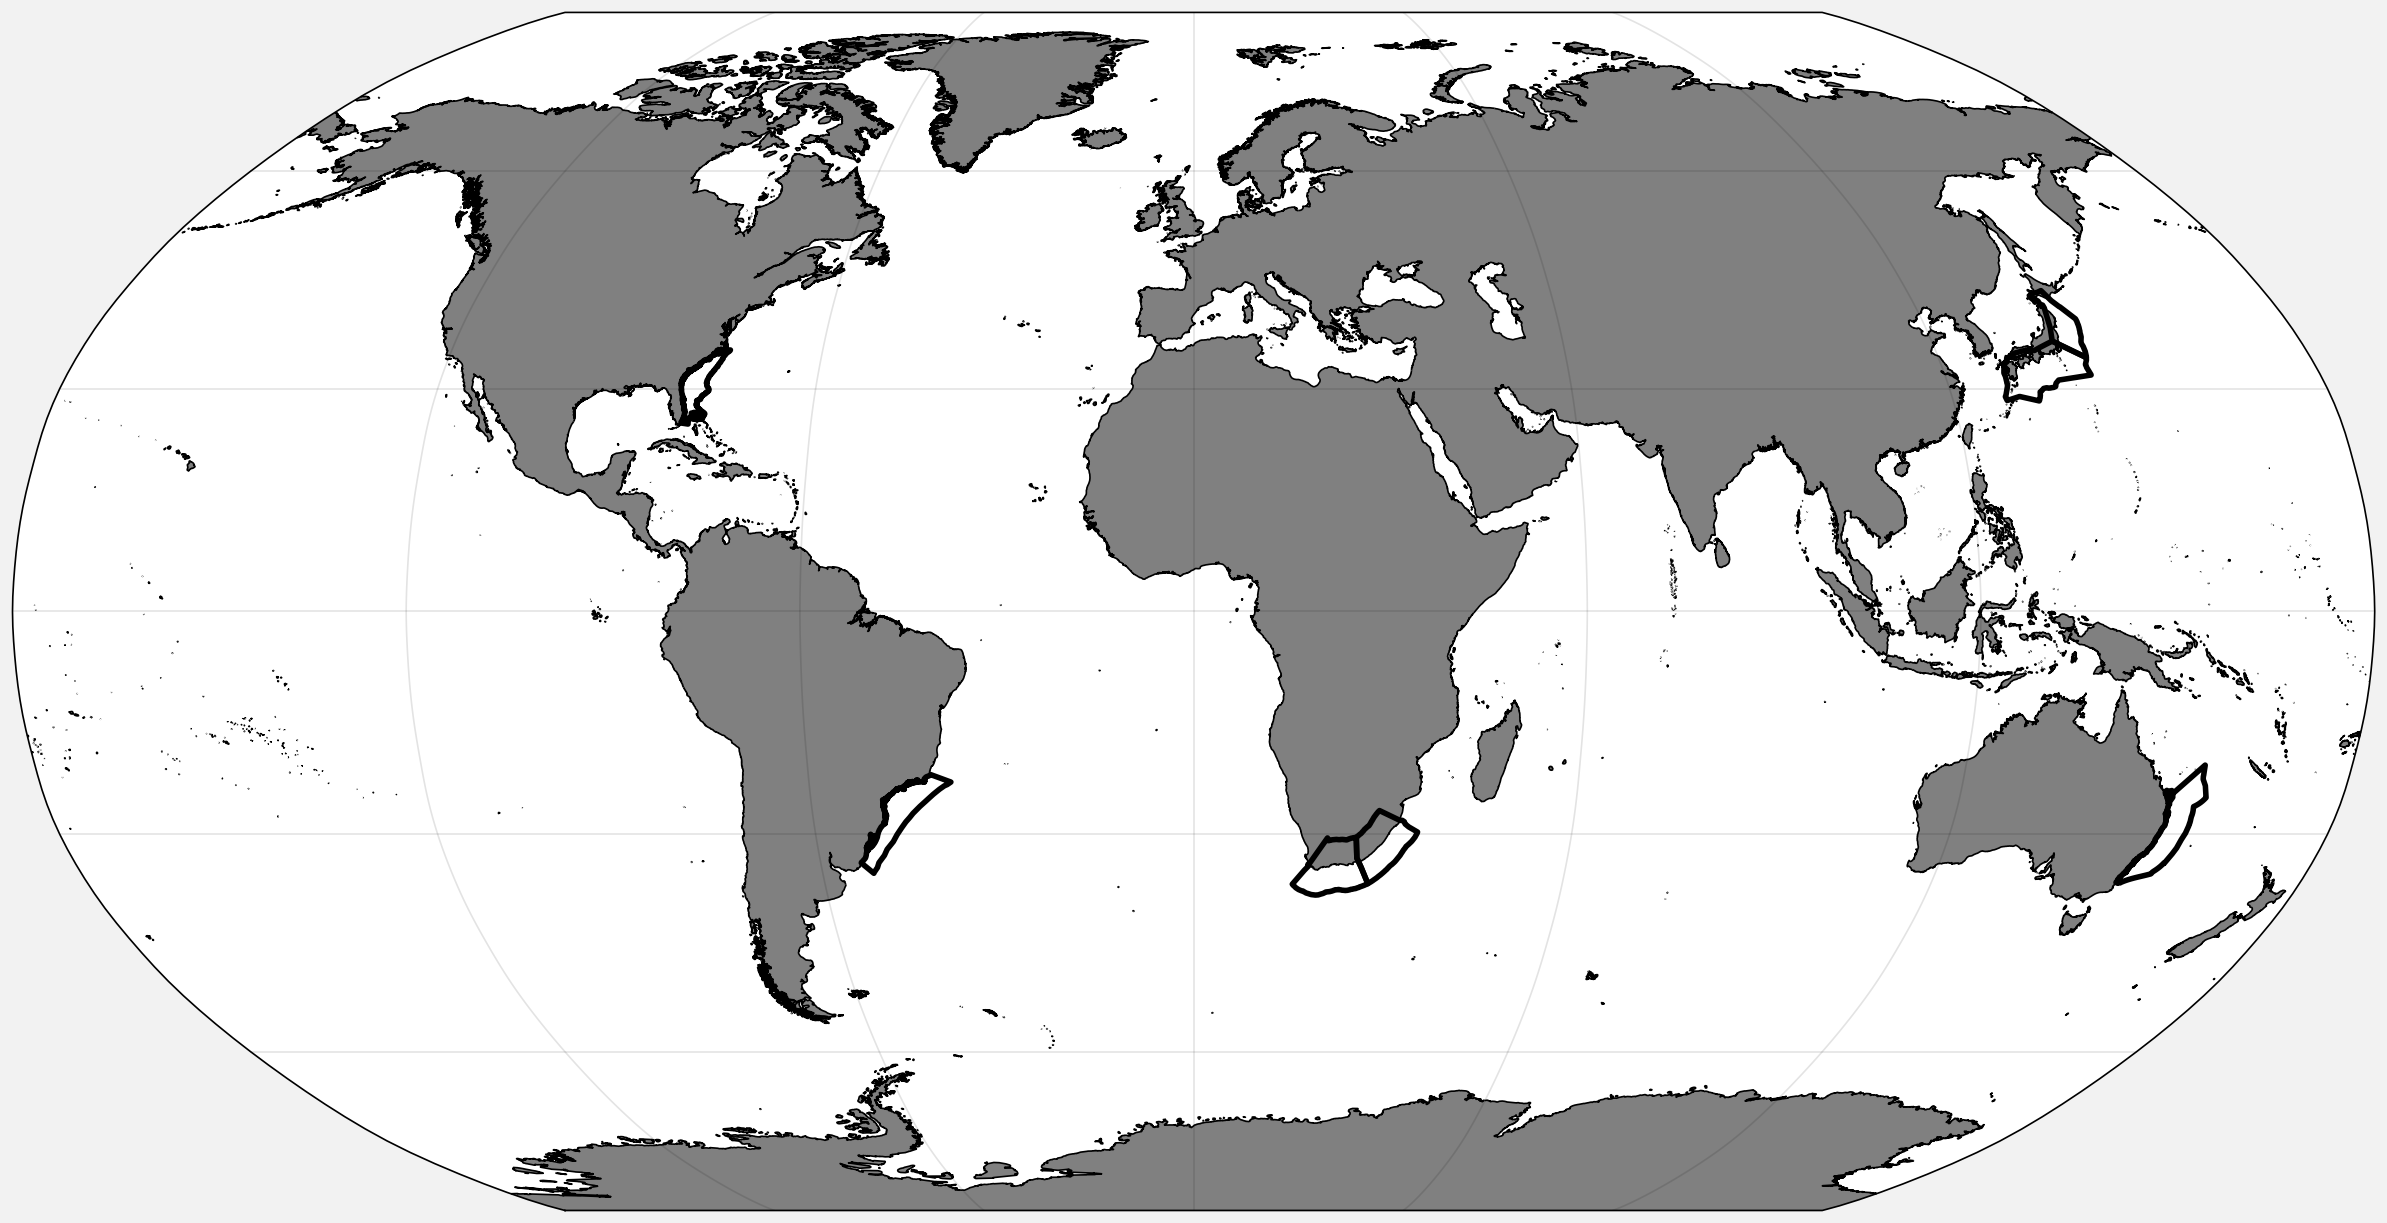

In [7]:
import proplot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,mark_inset
import cartopy
import cartopy.crs as ccrs
from shapely.geometry.polygon import LinearRing





proplot.rc['land.color'] = 'grey'
proplot.rc['text.labelsize'] = 15
proplot.rc['text.titlesize'] = 25
proplot.rc['abc.size'] = 15
proplot.rc['abc.style'] = 'a'
proplot.rc.reso = 'hi'

#SW Tas Domain
#lon_min = 143
#lon_max = 150
#lat_min = -45
#lat_max = -40


#bathymetry = topo_dataset['z'].where(topo_dataset['z']<0)

proj = proplot.Proj('robin', basemap=False)


#plt.figure(1,figsize=(20,10))
fig, axs = proplot.subplots(nrows=1, ncols=1,axwidth='30cm',aspect=2.5,proj=proj)
axs.format(abc=False,share=0) #, color='grey')

#cs = axs[0].contourf(bathymetry['x'],bathymetry['y'],-bathymetry,levels=np.linspace(0,5000,30),cmap='deep',extend='both')
#axs[0].contour(bathymetry['x'],bathymetry['y'],-bathymetry,levels=[100,200,500,1000],colors='black')
#
axs[0].format(land=True,coast=True,facecolor='white') 
                            #lonlim=(lon_min, lon_max), latlim=(lat_min, lat_max), 
                            #labels=True,lonlines=np.arange(0,360,2),latlines=np.arange(-50,50,1))

#axs[0].colorbar(cs,ticks=[5000,4000,3000,2000,1000,0],label='Depth (m)')
#codes_to_get = [20070,25042,20192,20193,20180,20181,20202,20203,20204,20051,20048]
codes_to_get = [20192,20193,20051,20048]

#codes_to_get = [192,193,51,42,70,180,181,202,203,204]
for record, geometry in zip(SAU_LME_regions.records(), SAU_LME_regions.geometries()):
    eco_code = record.attributes['ECO_CODE'] #-20000
    if 'Northwest Pacific' in record.attributes['PROVINCE']:
        print(eco_code, record.attributes['ECOREGION'])
    if int(eco_code) in codes_to_get:
    #if record.attributes['PROVINCE'] == 'Tropical Northwestern Atlantic':
        #print(eco_code,  record.attributes['ECOREGION'])
        axs[0].add_geometries([geometry], ccrs.PlateCarree(), facecolor="none",
                      edgecolor='black',alpha=1.0,linewidth=2.0)

for record, geometry in zip(LME_regions.records(), LME_regions.geometries()):
    
    if record.attributes['LME_NAME'] in ['Southeast U.S. Continental Shelf','East Central Australian Shelf','South Brazil Shelf']:
        axs[0].add_geometries([geometry], ccrs.PlateCarree(), facecolor="none",
            edgecolor='black',alpha=1.0,linewidth=2.0)

    
#dsad
figure_output_path = './Figures/'
figure_file_name = 'Blah'
#plt.savefig(os.path.join(figure_output_path,figure_file_name + '.png'),dpi=400)
#plt.savefig(os.path.join(figure_output_path,figure_file_name + '.pdf'),dpi=200)


In [8]:
chla_base_path = '/home/observations/rs/colour/modis/monthly' 
#chla_file = 'A20083362008366.L3m_MO_CHL_chlor_a_4km.nc'

file_list = os.listdir(chla_base_path)

files_to_get = []

for i_file in file_list:
    if os.path.isfile(os.path.join(chla_base_path,i_file)) and i_file.startswith('A') and i_file.endswith('CHL_chlor_a_4km.nc'):
        files_to_get.append(os.path.join(chla_base_path,i_file))
        

files_to_get.sort()


first_pass = True
                       
date_counter = 0
for i_file in files_to_get:

    
        
    chla_dataset = xarray.open_dataset(i_file) #
    chla_dataset = align_lon(chla_dataset,['lon'])
    #chla_dataset = chla_dataset.sel(lon=slice(LON_WEST,LON_EAST),lat=slice(LAT_NORTH,LAT_SOUTH))
    if first_pass:
        latitude_chla  = chla_dataset['lat'] #.sel(lat=slice(30,-70))
        longitude_chla = chla_dataset['lon'] # .sel(lon=slice(0,180))
        chla      = np.zeros([len(files_to_get),latitude_chla.size,longitude_chla.size],dtype=np.float32)
        chla_dates = np.zeros(len(files_to_get),dtype='datetime64[D]')
        first_pass = False
    
    date_shift = pandas.Timedelta ( (pandas.Timestamp(chla_dataset.attrs['time_coverage_end'][0:10]) -pandas.Timestamp(chla_dataset.attrs['time_coverage_start'][0:10]) )/pandas.Timedelta(2,'d'),'d' )
    time = pandas.Timestamp(chla_dataset.attrs['time_coverage_start'][0:10]) + date_shift
    #print(time)
    chla[date_counter,:,:] = chla_dataset['chlor_a']
    chla_dates[date_counter] = time
    chla_dataset.close()
    date_counter = date_counter+1

chla_dataset = xarray.DataArray(chla,dims=['time','lat','lon'],coords={'time':chla_dates,'lat':latitude_chla,'lon':longitude_chla})                  


In [9]:
chla_dataset_year_avg = chla_dataset.groupby('time.year').mean('time')
chla_dataset_total_avg = chla_dataset_year_avg.mean('year')

chla_dataset_year_std = chla_dataset.groupby('time.year').std('time')


In [10]:
chla_dataset_year_avg

<xarray.DataArray (year: 21, lat: 4320, lon: 8640)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 89.98 89.94 89.9 89.85 ... -89.85 -89.9 -89.94 -89.98
  * lon      (lon) float32 0.02084 0.0625 0.1042 0.1458 ... 359.9 359.9 360.0
  * year     (year) int64 2002 2003 2004 2005 2006 ... 2018 2019 2020 2021 2022

chla_dataset_clim = chla_dataset.groupby('time.month').mean('time')
chla_dataset_anom = chla_dataset.groupby('time.month') - chla_dataset_clim


**Plots of Chl-a**

/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/proplot/axes/geo.py:1045: ProPlotWarning: Cannot add gridline labels to cartopy Robinson projection.
/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/proplot/axes/geo.py:1051: ProPlotWarning: Cannot add gridline labels to cartopy Robinson projection.


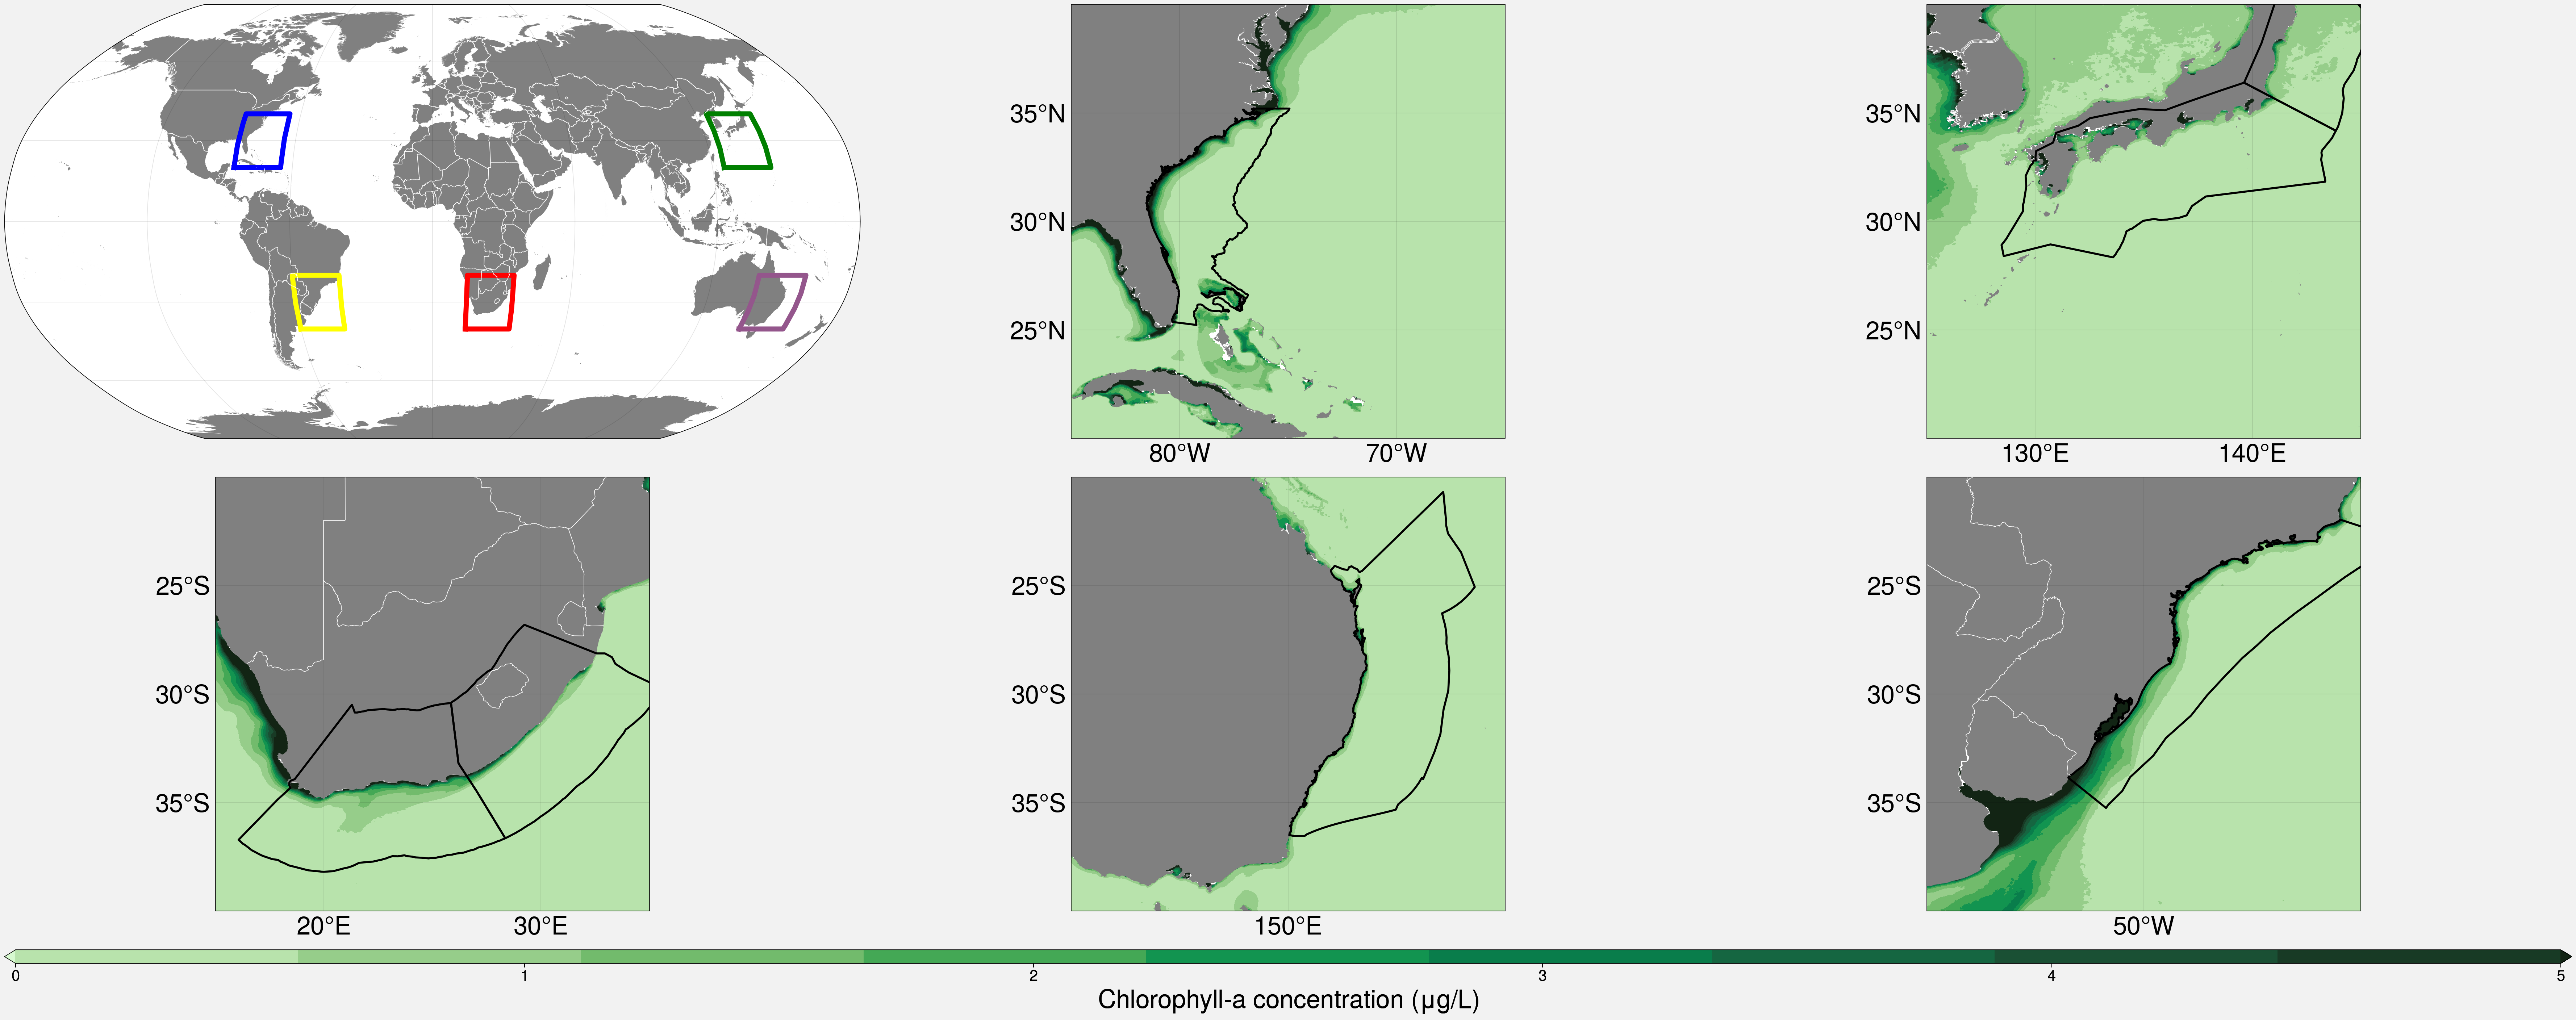

In [34]:
lon_lims = [[-85,-65],
            [125,145],
            [15,35],
            [140,160],
            [-60,-40]
            ]
lat_lims = [[20,40],
            [20,40],
            [-40,-20],
            [-40,-20],
            [-40,-20]]



proplot.rc['land.color'] = 'grey'
proplot.rc['text.labelsize'] = 25
proplot.rc['text.titlesize'] = 25
proplot.rc['abc.size'] = 15
proplot.rc['abc.style'] = 'a'
proplot.rc['subplots.tight'] = True

proplot.rc.reso = 'hi'


proj = [proplot.Proj('robin', basemap=False) , 
        proplot.Proj('cyl', basemap=False),
        proplot.Proj('cyl', basemap=False),
        proplot.Proj('cyl', basemap=False),
        proplot.Proj('cyl', basemap=False),
        proplot.Proj('cyl', basemap=False)]

color_box = ['blue','green','red','purple','yellow']
LMEs_to_get = ['Southeast U.S. Continental Shelf','East Central Australian Shelf','South Brazil Shelf']
SAU_LMES_to_get = ['Central Kuroshio Current','Northeastern Honshu','Agulhas Bank','Natal']

#plt.figure(1,figsize=(20,10))
fig, axs = proplot.subplots(nrows=2, ncols=3,axwidth='30cm',aspect=2.5,proj=proj,sharex=True,sharey=True)
axs.format(
    land=True, labels=True,
    borders=True, borderscolor='white')

for i_region in range(0,len(lon_lims)):
    
    current_lon_lims = lon_lims[i_region]
    current_lat_lims = lat_lims[i_region]
    
    
    box_lon = [current_lon_lims[0],current_lon_lims[0],current_lon_lims[1],current_lon_lims[1],current_lon_lims[0]]
    box_lat = [current_lat_lims[0],current_lat_lims[1],current_lat_lims[1],current_lat_lims[0],current_lat_lims[0]]
    
    axs[0].plot(box_lon,box_lat,linewidth=5,color=color_box[i_region])

axis_counter = 1
for i_region in range(0,len(lon_lims)):

    current_lon_lims = lon_lims[i_region]
    current_lat_lims = lat_lims[i_region]
    
    for i_lon_lim in range(0,len(current_lon_lims)):
        if current_lon_lims[i_lon_lim]<0:
            converted_lon_lim = 360-np.abs(current_lon_lims[i_lon_lim])
            current_lon_lims[i_lon_lim] = converted_lon_lim
    
    #print(current_lon_lims)
    #print(current_lat_lims)
    cs = axs[axis_counter].contourf(chla_dataset_year_avg['lon'].sel(lon=slice(current_lon_lims[0]-1,current_lon_lims[1]+1)),
                chla_dataset_year_avg['lat'].sel(lat=slice(current_lat_lims[1]+1,current_lat_lims[0]-1)),
                chla_dataset_total_avg.sel(lat=slice(current_lat_lims[1]+1,current_lat_lims[0]-1),
                                           lon=slice(current_lon_lims[0]-1,current_lon_lims[1]+1)),
                                           levels=np.linspace(0,5,10),cmap='algae',extend='both')


    #codes_to_get = [192,193,51,42,70,180,181,202,203,204]
    
    for record, geometry in zip(SAU_LME_regions.records(), SAU_LME_regions.geometries()):
        eco_code = record.attributes['ECOREGION'] #-20000
        if eco_code in SAU_LMES_to_get:
            axs[axis_counter].add_geometries([geometry], ccrs.PlateCarree(), facecolor="none",
                      edgecolor='black',alpha=1.0,linewidth=2.0)
    
    for record, geometry in zip(LME_regions.records(), LME_regions.geometries()):
    
        if record.attributes['LME_NAME'] in LMEs_to_get:
            axs[axis_counter].add_geometries([geometry], ccrs.PlateCarree(), facecolor="none",
                                  edgecolor='black',alpha=1.0,linewidth=2.0)

    
    
    axs[axis_counter].format(lonlim=current_lon_lims, latlim=current_lat_lims,latlines=5, lonlines=10)
    axis_counter = axis_counter + 1
cbar = fig.colorbar(cs,loc='bottom',ticks=np.arange(0,5.1,1),) 
cbar.set_label(label=r'Chlorophyll-a concentration ($\mu$g/L)',size=25)
cbar.ax.tick_params(labelsize=15) 

fig_name = 'WBC_compendium_Chla_distribution_5_WBCs'

fig_path = './'
fig.savefig(os.path.join(fig_path,fig_name + '.png'),dpi=400) 
fig.savefig(os.path.join(fig_path,fig_name + '.pdf'),dpi=200)    


In [207]:
a =1
b=1
print(a+b)

2


In [23]:
from shapely.geometry import Point, Polygon
from shapely.geometry import Polygon, mapping
import matplotlib.path as matplotlib_path

x_points,y_points = np.meshgrid(longitude_chla,latitude_chla)

lon_lims = [[-90,-40],
            [125,165],
            [10,45],
            [145,165],
            [-70,-35]
            ]
lat_lims = [[20,50],
            [20,50],
            [-50,-20],
            [-50,-20],
            [-50,-20]]

#lon_lims = [[10,45]]
#lat_lims = [[-50,-20]]

LMEs_to_get = ['Southeast U.S. Continental Shelf','East Central Australian Shelf','South Brazil Shelf']
SAU_LMES_to_get = ['Central Kuroshio Current','Northeastern Honshu','Agulhas Bank','Natal']

chla_in_LME_object = {}
for i_region in range(0,len(lon_lims)):

    current_lon_lims = lon_lims[i_region]
    current_lat_lims = lat_lims[i_region]
    
    for i_lon_lim in range(0,len(current_lon_lims)):
        if current_lon_lims[i_lon_lim]<0:
            converted_lon_lim = 360-np.abs(current_lon_lims[i_lon_lim])
            current_lon_lims[i_lon_lim] = converted_lon_lim
    
    lat_region = chla_dataset_year_avg['lat'].sel(lat=slice(current_lat_lims[1]+1,current_lat_lims[0]-1)).values
    lon_region = chla_dataset_year_avg['lon'].sel(lon=slice(current_lon_lims[0]-1,current_lon_lims[1]+1)).values
    chla_dataset_year_avg_sub_region = chla_dataset_year_avg.sel(lon=slice(current_lon_lims[0]-1,current_lon_lims[1]+1),
                                                                 lat=slice(current_lat_lims[1]+1,current_lat_lims[0]-1))
    chla_dataset_year_std_sub_region = chla_dataset_year_std.sel(lon=slice(current_lon_lims[0]-1,current_lon_lims[1]+1),
                                                                 lat=slice(current_lat_lims[1]+1,current_lat_lims[0]-1))
    
    #chla_dataset_year_avg_sub_region[0,:,:].plot(vmin=0,vmax=1)
    #dsada
    
    #mask = np.zeros([lat_region.size,lon_region.size],dtype='int32')
    #codes_to_get = [20192,20193,20051,20048]
    
    #integrated_output = mask_inside_boundaries(chla_dataset_year_std_sub_region,SAU_LME_regions,'ECOREGION',SAU_LMES_to_get,
    #                       eco_region_key = 'ECOREGION',sensor_dims=['lat','lon'])
    
    
    #for i_key in integrated_output.keys():
    #    chla_in_LME_object[i_key] = integrated_output[i_key]

    
    integrated_output = mask_inside_boundaries(chla_dataset_year_std_sub_region,LME_regions,'LME_NAME',LMEs_to_get,
                           eco_region_key = 'LME_NAME',sensor_dims=['lat','lon'],shift_lons_to_n180_p180=True)

    for i_key in integrated_output.keys():
        chla_in_LME_object[i_key] = integrated_output[i_key]
    
    
    integrated_output = mask_inside_boundaries(chla_dataset_year_std_sub_region,SAU_LME_regions,'ECOREGION',SAU_LMES_to_get,
                           eco_region_key = 'ECOREGION',sensor_dims=['lat','lon'],shift_lons_to_n180_p180=False)

    for i_key in integrated_output.keys():
        chla_in_LME_object[i_key] = integrated_output[i_key]
    


In [26]:
chla_in_LME_object

{'Southeast U.S. Continental Shelf_time_avg': 0.2744141221046448,
 'Southeast U.S. Continental Shelf_time_std': 0.0592912882566452,
 'Central Kuroshio Current_time_avg': 0.25540897250175476,
 'Central Kuroshio Current_time_std': 0.04090387001633644,
 'Northeastern Honshu_time_avg': 0.666728675365448,
 'Northeastern Honshu_time_std': 0.2115098536014557,
 'Agulhas Bank_time_avg': 0.38128525018692017,
 'Agulhas Bank_time_std': 0.08181434869766235,
 'Natal_time_avg': 0.18631508946418762,
 'Natal_time_std': 0.02805580385029316,
 'East Central Australian Shelf_time_avg': 0.11496657133102417,
 'East Central Australian Shelf_time_std': 0.017096655443310738,
 'South Brazil Shelf_time_avg': 0.4427036643028259,
 'South Brazil Shelf_time_std': 0.13253089785575867}

In [62]:
chla_in_LME_object.keys()

dict_keys(['Central Kuroshio Current_time_avg', 'Central Kuroshio Current_time_std', 'Northeastern Honshu_time_avg', 'Northeastern Honshu_time_std', 'Agulhas Bank_time_avg', 'Agulhas Bank_time_std', 'Natal_time_avg', 'Natal_time_std', 'East Central Australian Shelf_time_avg', 'East Central Australian Shelf_time_std'])

In [31]:
output_dataframe = {'Agulhas_average': chla_in_LME_object['Agulhas Bank_time_avg']+chla_in_LME_object['Natal_time_avg'],
     'Agulhas_2std':      2.0*(chla_in_LME_object['Northeastern Honshu_time_std']+chla_in_LME_object['Natal_time_std']),
     
     'Gulf_stream_average':chla_in_LME_object['Southeast U.S. Continental Shelf_time_avg'],
     'Gulf_stream_2std':   2.0*chla_in_LME_object['Southeast U.S. Continental Shelf_time_std'],
     
     'Kuroshio_average': chla_in_LME_object['Northeastern Honshu_time_avg']  +chla_in_LME_object['Central Kuroshio Current_time_avg'],
     'Kuroshio_2std': 2.0*(chla_in_LME_object['Northeastern Honshu_time_std']+chla_in_LME_object['Central Kuroshio Current_time_std']),

     'EAC_average':chla_in_LME_object['East Central Australian Shelf_time_avg'],
     'EAC_2std': 2.0*chla_in_LME_object['East Central Australian Shelf_time_std'],
     
     'Brazil_average':chla_in_LME_object['South Brazil Shelf_time_avg'],
     'Brazil_2std':   2.0*chla_in_LME_object['South Brazil Shelf_time_std']
    }
output_dataframe = pandas.DataFrame(data=output_dataframe,index=["chl_a"])


In [32]:
output_dataframe

,Agulhas_average,Agulhas_2std,Gulf_stream_average,Gulf_stream_2std,Kuroshio_average,Kuroshio_2std,EAC_average,EAC_2std,Brazil_average,Brazil_2std
chl_a,0.5676,0.479131,0.274414,0.118583,0.922138,0.504827,0.114967,0.034193,0.442704,0.265062


In [365]:
output_dataframe.to_csv('WBC_chla_compendium.csv', index=False)  